In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from kmodes.kprototypes import KPrototypes
from dateutil.parser import parse

from time import time

pd.set_option("display.max_columns", None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#On modifie les options pour rendre l'affichage des float plus lisible
pd.set_option('float_format', '{:f}'.format)

## Import des datasets fournis par le client

In [3]:
df = pd.read_csv("df.csv", sep=',', index_col=[0])

In [4]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"],
                              format="%Y-%m-%d", errors="ignore")

### Segmentation de dates

In [5]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1.000000,credit_card,1.000000,18.120000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
1,e481f51cbdc54678b7cc49136f2d6af7,3.000000,voucher,1.000000,2.000000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
2,e481f51cbdc54678b7cc49136f2d6af7,2.000000,voucher,1.000000,18.590000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
3,53cdb2fc8bc7dce0b6741e2150273451,1.000000,boleto,1.000000,141.460000,8d5266042046a06655c8db133d120ba5,4.000000,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13.782037
4,47770eb9100c2d0c44946d9cf07ec65d,1.000000,credit_card,3.000000,179.120000,e73b67b67587f7644d5bd1a52deb1b01,5.000000,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.394213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,1.000000,credit_card,3.000000,85.080000,e262b3f92d1ce917aa412a9406cf61a6,5.000000,2017-03-22 00:00:00,2017-03-23 11:02:08,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,-23.172205,-45.880056,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,8.218009
104474,63943bddc261676b46f01ca7ac2f7bd8,1.000000,credit_card,3.000000,195.000000,29bb71b2760d0f876dfa178a76bc4734,4.000000,2018-03-01 00:00:00,2018-03-02 17:50:01,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,praia grande,-24.001467,-46.446355,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,22.193727
104475,83c1379a015df1e13d02aae0204711ab,1.000000,credit_card,5.000000,271.010000,371579771219f6db2d830d50805977bb,5.000000,2017-09-22 00:00:00,2017-09-22 23:10:57,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,-17.891522,-39.370942,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,24.859421
104476,11c177c8e97725db2631073c19f07b62,1.000000,credit_card,4.000000,441.160000,8ab6855b9fe9b812cd03a480a25058a1,2.000000,2018-01-26 00:00:00,2018-01-27 09:16:56,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,-22.555985,-42.690761,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,17.086424


In [6]:
df = df.drop(['payment_sequential', 'payment_type', 'payment_installments', 'review_id', 'review_creation_date', 'review_answer_timestamp', 'customer_id', 'customer_city', 'geolocation_lat', 'geolocation_lng', 'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)

In [7]:
df.set_index('customer_unique_id')

,order_id,payment_value,review_score,order_purchase_timestamp,delivery_time
customer_unique_id,,,,,
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,18.120000,4.000000,2017-10-02 10:56:33,8.436574
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2.000000,4.000000,2017-10-02 10:56:33,8.436574
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,18.590000,4.000000,2017-10-02 10:56:33,8.436574
af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,141.460000,4.000000,2018-07-24 20:41:37,13.782037
3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,179.120000,5.000000,2018-08-08 08:38:49,9.394213
...,...,...,...,...,...
6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,85.080000,5.000000,2017-03-09 09:54:05,8.218009
da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,195.000000,4.000000,2018-02-06 12:58:58,22.193727
737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,271.010000,5.000000,2017-08-27 14:46:43,24.859421


In [8]:
first_date = df["order_purchase_timestamp"].min()
last_date = df["order_purchase_timestamp"].max()

In [9]:
first_date

Timestamp('2016-09-04 21:15:19')

In [10]:
last_date

Timestamp('2018-10-17 17:30:18')

In [11]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)
snapshot_date

Timestamp('2018-10-18 17:30:18')

In [12]:
date = first_date
cpt_date = 0
while(date < last_date):
    cpt_date += 1
    date = date+relativedelta(months=+1)
print(cpt_date)

26


In [13]:
from dateutil.relativedelta import relativedelta
dataframes = []
for i in range(1, 27):
    dataframes.append(df.loc[df["order_purchase_timestamp"] <= first_date+relativedelta(months=+i)])

In [14]:
df1 = df.loc[df["order_purchase_timestamp"] <= first_date+relativedelta(months=+1)]

In [15]:
dfs = []
for data in dataframes:
    data = data.groupby("customer_unique_id").agg({
        "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
        "order_id" : 'count',
        "payment_value" : "mean",
        "review_score" : "mean",
        "delivery_time" : "mean",
    })    
    data.columns = ["Récence", "Fréquence", "Montant","Avis","Delivery_time"]
    data = data.copy().reset_index()
    data = data.dropna()
    dfs.append(data)


In [16]:
while(len(dfs[0]) < 20000):
    dfs.pop(0)

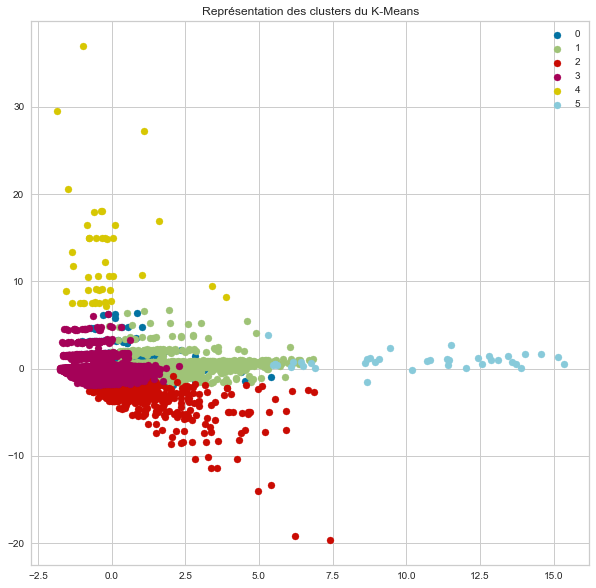

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.style import set_palette

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = dfs[0][["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

km = KMeans(n_clusters=6, random_state=1)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()
true_label1 = label

In [18]:
predict_labels = []

for df in dfs:
    data_pca = df[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

    X = data_pca.values
    features = data_pca.columns
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    pcs = pca.components_

    predict_labels.append(km.predict(X_scaled))

In [19]:
true_labels = []

for df in dfs:

    data_pca = df[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

    X = data_pca.values
    features = data_pca.columns
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    pcs = pca.components_

    true_labels.append(km.fit_predict(X_scaled))

In [20]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [21]:
days = []
ari = []
for i in range(len(true_labels)):
    ari.append(adjusted_rand_score(true_labels[i], predict_labels[i]))
    days.append(15*i)
    print("Score ARI pour", 15*i, "jours : ", ari[i])

df_ari = pd.DataFrame({'ari': ari, 'days': days})

Score ARI pour 0 jours :  1.0
Score ARI pour 15 jours :  0.8975365028981804
Score ARI pour 30 jours :  0.9024443134063183
Score ARI pour 45 jours :  0.8462384175994129
Score ARI pour 60 jours :  0.8411266144307751
Score ARI pour 75 jours :  0.8174857779665406
Score ARI pour 90 jours :  0.8052831903438203
Score ARI pour 105 jours :  0.7996749573091398
Score ARI pour 120 jours :  0.8190692793475889
Score ARI pour 135 jours :  0.8265879500030157
Score ARI pour 150 jours :  0.8257303486617397
Score ARI pour 165 jours :  0.8662795897713914
Score ARI pour 180 jours :  0.8588373419268092
Score ARI pour 195 jours :  0.8588373419268092
Score ARI pour 210 jours :  0.8588373419268092


<AxesSubplot:xlabel='days', ylabel='ari'>

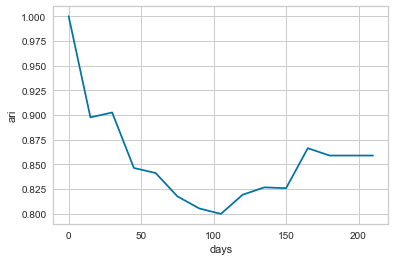

In [22]:
sns.lineplot(data=df_ari, x="days", y="ari")